In [1]:
import os
import sys
import time
import json
import datetime
import math
import pdb
import argparse
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything
from collections import defaultdict
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler, StableDiffusionImg2ImgPipeline
from lora_diffusion import patch_pipe, tune_lora_scale

os.environ["DISABLE_TELEMETRY"] = 'YES'
os.environ["HTTP_PROXY"] = "http://localhost:8890"
os.environ["HTTPS_PROXY"] = "http://localhost:8890"

device = torch.device("cuda")
time.sleep(0.01)
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("models/stable-diffusion-v1-5", torch_dtype=torch.float16,
                                                      revision='39593d5650112b4cc580433f6b0435385882d819', safety_checker=None, local_files_only=True).to(device)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipe.scheduler.config, )
pipe.set_progress_bar_config(disable=True)

2023-12-29 00:22:25.001820: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [2]:
import os
from PIL import Image
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt


def image_grid(_imgs, rows=None, cols=None):

    if rows is None and cols is None:
        rows = cols = math.ceil(len(_imgs) ** 0.5)

    if rows is None:
        rows = math.ceil(len(_imgs) / cols)
    if cols is None:
        cols = math.ceil(len(_imgs) / rows)

    w, h = _imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(_imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def calc_piq(fake_images, fake_targets, real_path, metric, anno='', device='cuda'):

    from piq import psnr, ssim, gmsd, fsim, vsi, mdsi, haarpsi, srsim, dss
    metric_functions = {
        "psnr": psnr, "ssim": ssim, "gmsd": gmsd,
        "fsim": fsim, "vsi": vsi, "mdsi": mdsi,
        "haarpsi": haarpsi, "srsim": srsim, "dss": dss
    }
    function = metric_functions[metric]

    # get target images and labels
    inferred_image_path = real_path
    list_of_idx = os.listdir(inferred_image_path)
    images_list, targets_list = [], []
    # load reconstructed images
    for idx in list_of_idx:
        for filename in os.listdir(os.path.join(inferred_image_path, idx)):
            image = Image.open(os.path.join(
                inferred_image_path, idx, filename))
            image = T.functional.to_tensor(image)
            images_list.append(image)
            targets_list.append(int(idx))
    real_images = torch.stack(images_list, dim=0).to(device)
    real_targets = torch.LongTensor(targets_list).to(device)

    # get fake images and labels
    fake_images = fake_images.to(device)
    fake_targets = fake_targets.to(device)
    bs = fake_targets.size(0)
    value = 0

    # calculate metric
    for i in range(bs):
        single_value = -1
        idx = torch.nonzero(real_targets == fake_targets[i]).squeeze(1)
        for j in idx:
            temp_value = function(fake_images[i].unsqueeze(
                0), real_images[j].unsqueeze(0))
            if temp_value > single_value:
                single_value = temp_value
        value += single_value
    value = (value / bs).item()
    print(f"{metric} : {value:.4f} {anno}")


def show_images_side_by_side(image1, image2, title1='Image 1', title2='Image 2'):
    """
    Display two PIL images side by side in a Jupyter Notebook.

    Parameters:
    - image1: PIL image object for the first image
    - image2: PIL image object for the second image
    - title1: Title for the first image (default is 'Image 1')
    - title2: Title for the second image (default is 'Image 2')
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1)
    axes[0].set_title(title1)

    axes[1].imshow(image2)
    axes[1].set_title(title2)

    for ax in axes:
        ax.axis('off')

    plt.show()

In [3]:
lora_ckpt = "logs/log_iper/person1/2023-12-28T22-55-39_person_baseline/lora_weight.safetensors"
ref_dir = "custom_datasets/iper_subset/person2"
batch_size = 1


__lora_ckpt__ = os.path.join(
    lora_ckpt, "lora_weight.safetensors") if ".safetensors" not in lora_ckpt else lora_ckpt
patch_pipe(
    pipe,
    __lora_ckpt__,
    patch_text=False,
    patch_ti=True,
    patch_unet=True,
    filter_crossattn_str="cross",
)
tune_lora_scale(pipe.unet, 1)

prompt_list = ["photo of a <krk1> person"]

seed_everything(0)

images = []
prompt_dataset = DataLoader(prompt_list, batch_size=batch_size)
for ref in sorted(os.listdir(ref_dir)):
    for prompts in tqdm(prompt_dataset, desc="Sampling"):
        with torch.autocast("cuda"):
            ref_img = Image.open(os.path.join(ref_dir, ref))
            imgs_ = pipe(image=ref_img, prompt=prompts, strength=0.5,
                         num_inference_steps=50, guidance_scale=5.0).images
            # imgs__ = [img.resize((512, 512), Image.BILINEAR) for img in imgs_]
        images.append((ref_img, imgs_[0]))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Global seed set to 0


Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:

import numpy as np
target_path = "/data/liox/_datasets/EDN/subject1"
calc_piq(images, np.arange(len(images)), target_path,
         metric='ssim', anno='', device='cuda')

SSIM: 0.7813


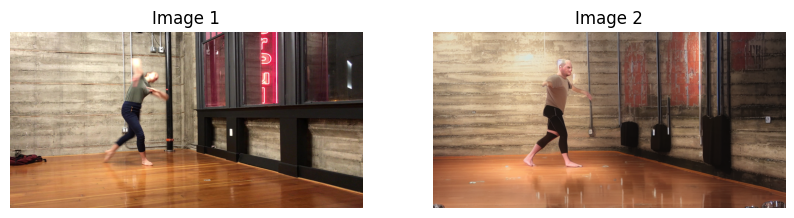

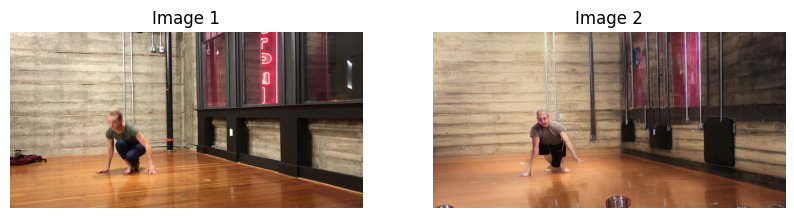

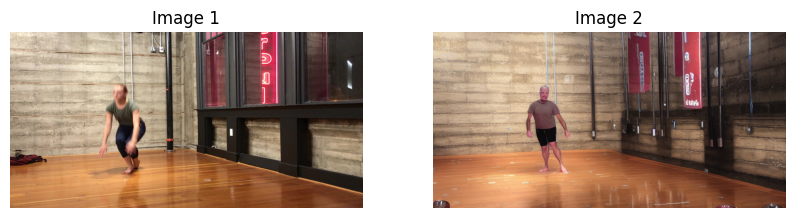

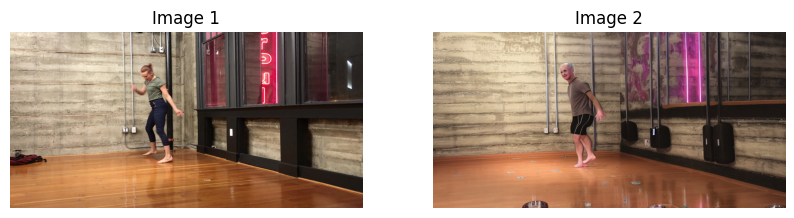

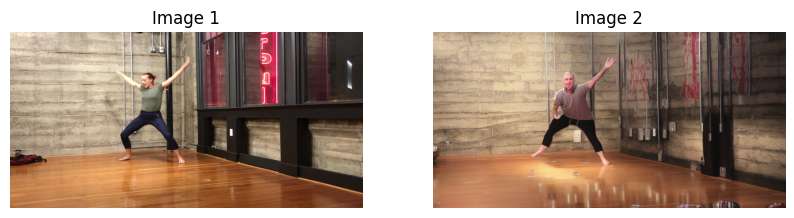

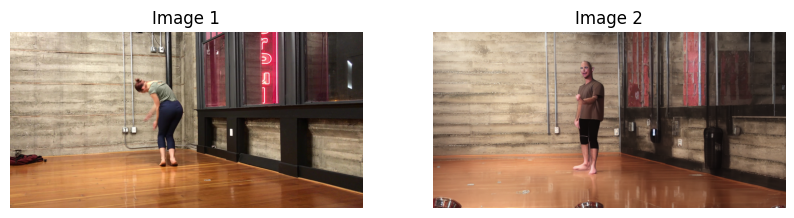

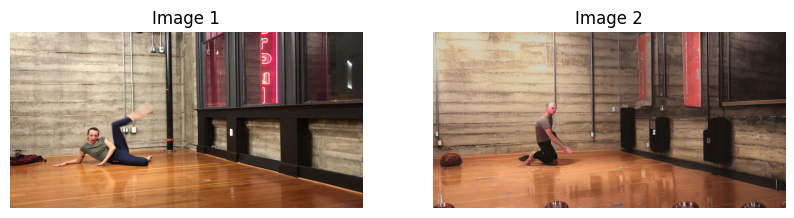

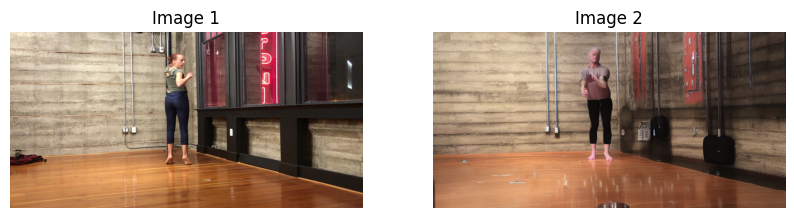

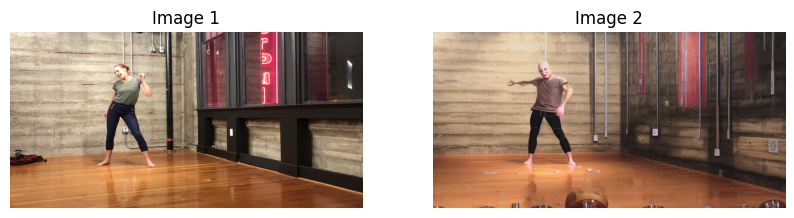

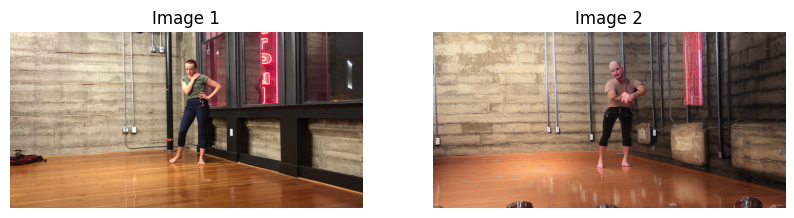

In [4]:
for image_show in images:
    show_images_side_by_side(image_show[0], image_show[1])